In [4]:
pip install pandas numpy statsmodels pydeseq2 matplotlib seaborn

Initial Data (first 5 rows):
         gene1  gene2  gene3  gene4  gene5  gene6  gene7  gene8  gene9  gene10
sample1     12     21      4    130     18      0     16     54     49       3
sample2      1     44      2     63     11     10     70     32     57       9
sample3      4      4     11    180     21      3     28     34     65       2
sample4      1     10      2    100     44      9     28     16     33       9
sample5      1     11      6    135     16      2     32     29     31       5

Differential Expression Results (first 10 rows):
       Gene   Log2_FC   P-value  Adj_P-value
0   sample1 -0.850094  0.546202          1.0
1   sample2  1.234341  0.320046          1.0
2   sample3 -0.114295  0.932549          1.0
3   sample4  0.496461  0.677744          1.0
4   sample5  0.110793  0.930510          1.0
5   sample6  1.502536  0.236271          1.0
6   sample7  0.655294  0.614140          1.0
7   sample8  0.576021  0.617199          1.0
8   sample9 -0.211839  0.831748          1

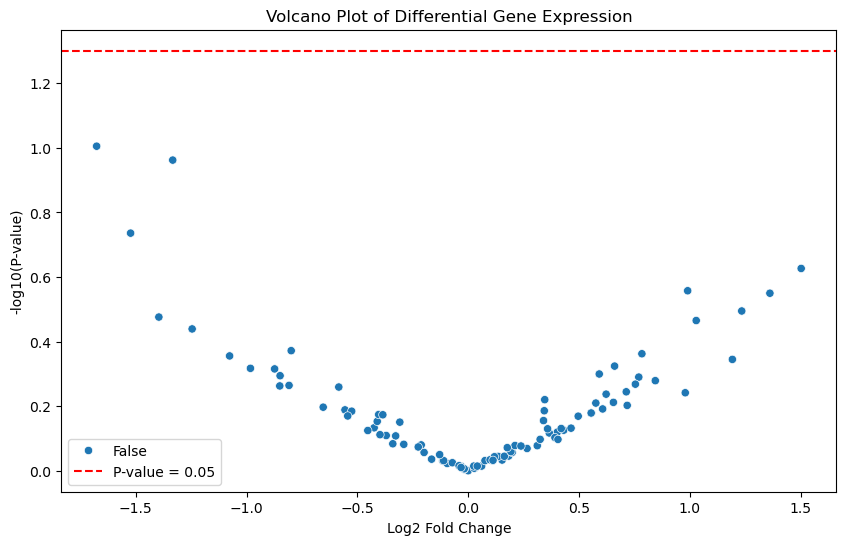

In [5]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import seaborn as sns
from pydeseq2.utils import load_example_data


counts_df = load_example_data()

num_samples = counts_df.shape[1]
conditions = ['Control'] * (num_samples // 2) + ['Treatment'] * (num_samples - (num_samples // 2))
metadata_df = pd.DataFrame({'condition': conditions}, index=counts_df.columns)

print("Initial Data (first 5 rows):")
print(counts_df.head())

conditions = metadata_df['condition'].tolist()

df_log = np.log2(counts_df + 1)


results = []
for gene in df_log.index:
    
    y = df_log.loc[gene].values.astype(float)
    X = pd.get_dummies(conditions, drop_first=True, dtype=int)
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    
    log2_fc = model.params.iloc[1]
    p_value = model.pvalues.iloc[1]
    results.append([gene, log2_fc, p_value])

results_df = pd.DataFrame(results, columns=['Gene', 'Log2_FC', 'P-value'])

results_df['Adj_P-value'] = multipletests(results_df['P-value'], method='fdr_bh')[1]

print("\nDifferential Expression Results (first 10 rows):")
print(results_df.head(10))

plt.figure(figsize=(10, 6))
sns.scatterplot(data=results_df, x='Log2_FC', y=-np.log10(results_df['P-value']), hue=results_df['Adj_P-value'] < 0.05)
plt.axhline(y=-np.log10(0.05), color='red', linestyle='--', label='P-value = 0.05')
plt.xlabel('Log2 Fold Change')
plt.ylabel('-log10(P-value)')
plt.title('Volcano Plot of Differential Gene Expression')
plt.legend()
plt.show()